<a href="https://colab.research.google.com/github/BognarAndras/Girls_day_2023/blob/main/Airbnb_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AirBnb price predictions.

#### After downloading the freely avaliable up-to-date [Airbnb data](http://insideairbnb.com/get-the-data/) for a specific city of your choosing, you are invited to explore the data to find the biggest factors for individual prices.

In [1]:
# First, install some useful libraries.
# For visualising maps:
!pip install geopandas
!pip install osmnx
!pip install shapely
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Point

# For managing data:

import pandas as pd 
import numpy as np
from datetime import datetime
from itertools import compress

# For visualizing data:

import seaborn as sns
import matplotlib.pyplot as plt

# For modelling factors behind prices:

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Exercise 1: Get source of data.

#### Choose the city you want to analyze. 

#### You can choose from 5 difference cities. Simply enter the name of city of your choice at the last line of the below chunk. Make sure to add **double quotes** before and after the city name to tell Python that it is a piece of text and not code.

In [2]:
# Get data URL for the AirBnb data of your city!

def get_url(city_name):
  city_dictionary = {
    "Barcelona": "http://data.insideairbnb.com/spain/catalonia/barcelona/2023-03-14/data/listings.csv.gz",
    "Rio de Janeiro": "http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2023-03-28/data/listings.csv.gz",
    "Venice": "http://data.insideairbnb.com/italy/veneto/venice/2023-03-07/data/listings.csv.gz",
    "Crete": "http://data.insideairbnb.com/greece/crete/crete/2023-03-30/data/listings.csv.gz",
    "Vienna": "http://data.insideairbnb.com/austria/vienna/vienna/2023-03-15/data/listings.csv.gz"
  }

  return(city_dictionary[city_name])

# ADD YOUR CITY BETWEEN THE PARENTHESES - example: get_url("Budapest")
city_url = get_url()

## Exercise 2: Load data.

#### Now that you know where to get your data from, load it by once again providing your city name as text in the appropriate place.

In [3]:
# Load data

def get_data(url):
  data = pd.read_csv(url)
  return(data)

df = get_data(city_url)

# ADD YOUR CITY HERE (example: "Budapest")
your_city = 

city = ox.geocode_to_gdf({'city': your_city})

#### Before going forward check how the data looks. Run the below chunk of code to visualize the location of each AirBnb.

/usr/local/lib/python3.9/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

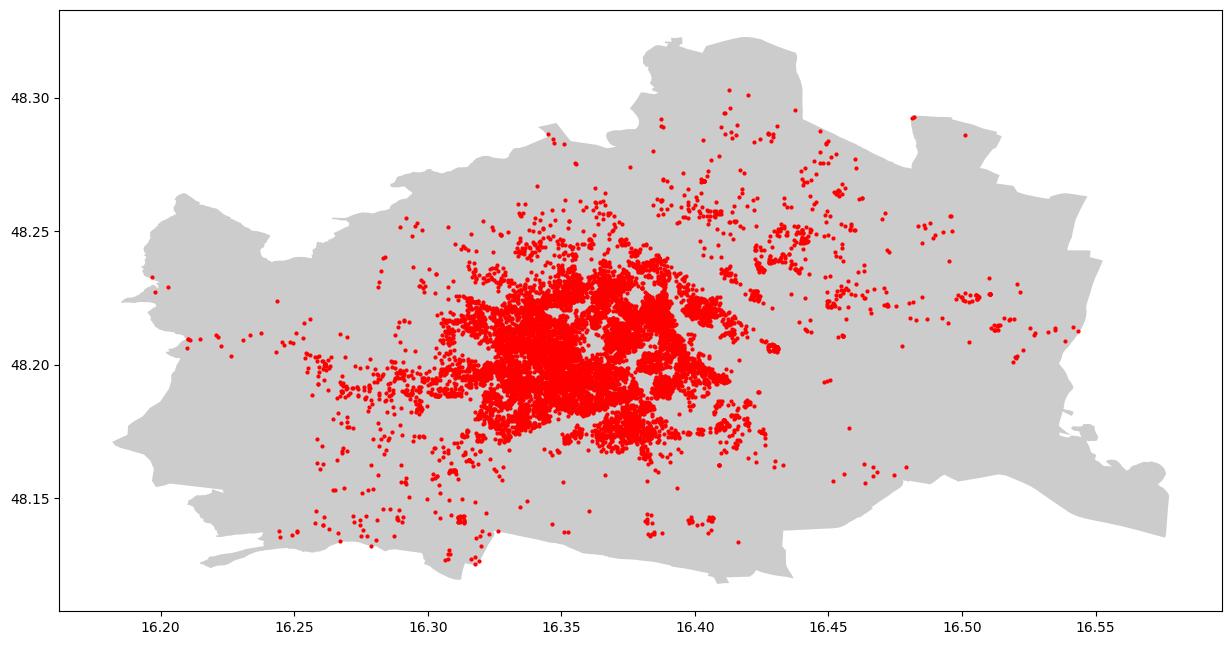

In [4]:
df['geometry'] = [Point(xy) for xy in zip(df.longitude, df.latitude)]
geo_df = gpd.GeoDataFrame(df, crs={"init": "epsg:4326"}, geometry=df["geometry"])
agg_geo_df = geo_df.groupby("name")["geometry"].first()
fig, ax = plt.subplots(figsize=(15, 15))
city.plot(ax=ax, color="grey", alpha=0.4)
agg_geo_df.plot(ax=ax, markersize=4, color="red", marker="o")

#### Since we are interesting in prices of AirBnbs, also check where the most expensive locations are.

/usr/local/lib/python3.9/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.9/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


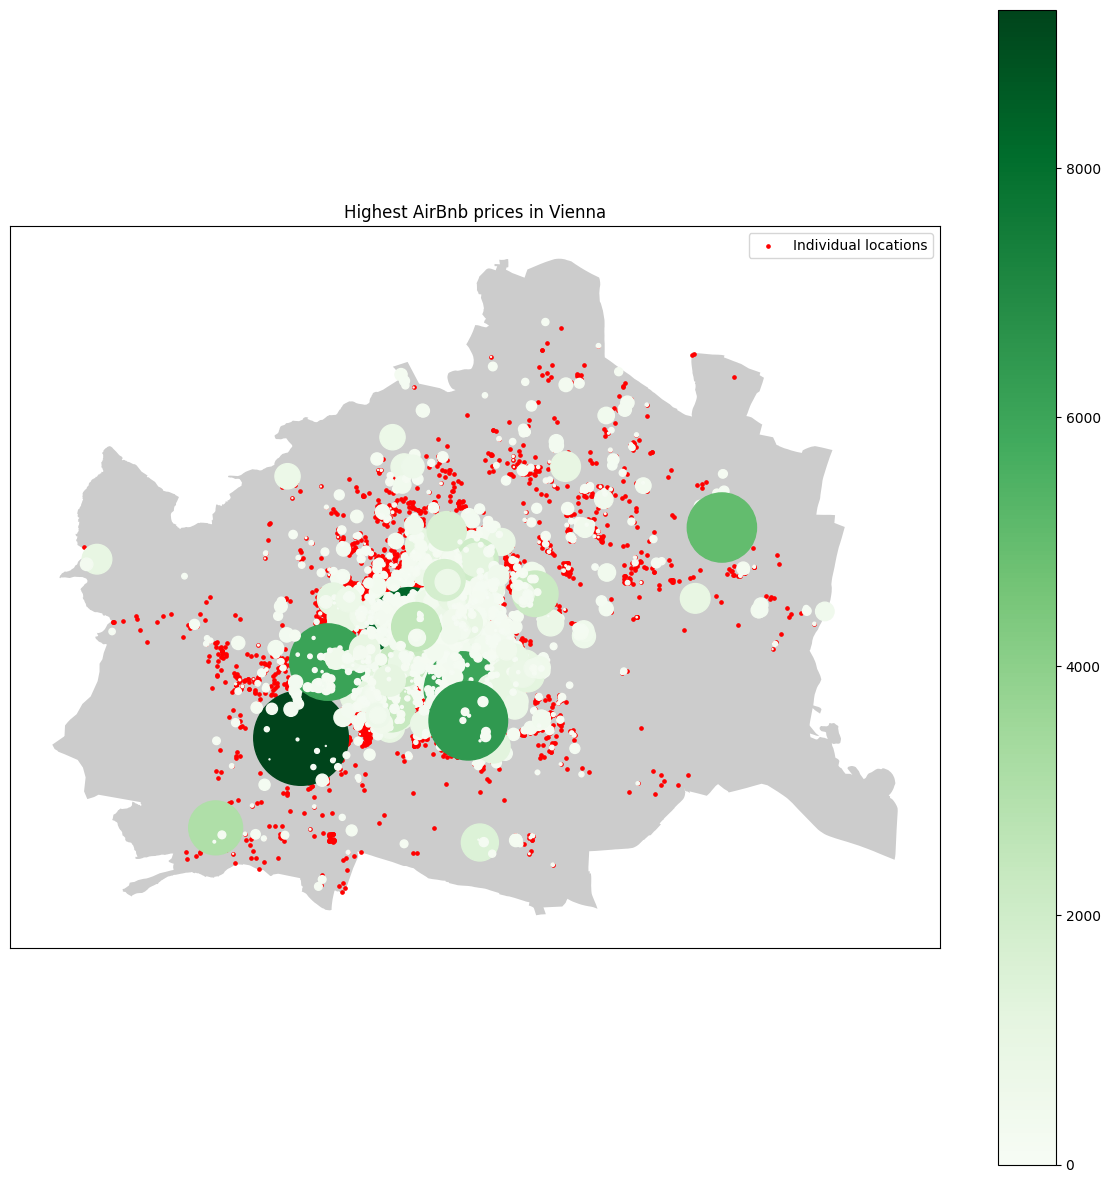

In [5]:
df['price_clean'] = df['price'].apply(lambda x: int(round(float(x.strip('$').replace(",","")))))
mm = StandardScaler()
agg = df.groupby(["name", "room_type"], as_index=False).agg({"price_clean": "sum", 
                                                                   "neighbourhood": "first",
                                                                   "geometry": "first"})
geo_agg = gpd.GeoDataFrame(agg, crs={"init": "epsg:4326"}, geometry=agg["geometry"])
geo_agg["price_size"] = mm.fit_transform(geo_agg[["price_clean"]])


max_amount = float(geo_agg["price_clean"].max())

fig, ax = plt.subplots(figsize=(15, 15))
city.plot(ax=ax, color="grey", alpha=0.4)


geo_agg.plot(ax=ax, markersize=5.5, color="red", marker="o", label="Individual locations")


geo_agg.plot(column="price_clean", 
             ax=ax, 
             markersize=100 * geo_agg["price_size"], 
             marker="o", 
             vmax=max_amount,
             cmap="Greens", 
             legend=True)

neighbourhood = "neighbourhood"
plt.xticks([], [])
plt.yticks([], [])
plt.title("Highest AirBnb prices in {}".format(your_city))
plt.legend()
plt.show()

#### Location is of course an important factor. But what else is important? To figure out get your data in shape for further analysis. 

#### You are only interested in the prices of houses and apartmants that have up to 5 bedrooms between 50 and 1100 dollars.


In [6]:
def clean_data(df):
  feature_df = df[df['property_type'].isin(["Entire rental unit", "Entire serviced apartment",
                             "Private room in rental unit", "Private room in serviced apartment"])]
                             
  feature_df = feature_df[(feature_df['accommodates'] > 1) & (feature_df['accommodates'] < 7)]
  feature_df = feature_df[feature_df['bedrooms'] < 6]

  feature_df = feature_df[(feature_df['price_clean'] > 50) & (feature_df['price_clean'] <= 1100)]
  feature_df = feature_df[["price_clean", "accommodates", "bedrooms", "property_type","room_type", "host_identity_verified","host_is_superhost","minimum_nights"]]
  feature_df['host_identity_verified'] = feature_df['host_identity_verified'].fillna('f')
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

  num_cols = list(feature_df.select_dtypes(include=numerics).columns)

  def factorize_text (data, columns):
    data[columns] = list(data[columns].factorize()[0])
    return data

  for col in list(feature_df.columns):
    if col not in num_cols:
      factorize_text(feature_df, col)
  return(feature_df)
df = clean_data(df)

#### Before going forward check how the data looks. Run the cells below to see how the data looks like and to visualize the location of each AirBnb.

In [7]:
# print the first 5 rows of the data
 
df.head(5)

,price_clean,accommodates,bedrooms,property_type,room_type,host_identity_verified,host_is_superhost,minimum_nights
0,79,5,1.0,0,0,0,0,5
1,123,6,2.0,0,0,0,1,1
2,77,2,1.0,0,0,0,1,90
4,65,4,1.0,0,0,0,1,30
5,140,6,2.0,0,0,0,1,3


#### Our models can only work with numeric inputs. Therefore, text columns have been converted to numbers. Check how property and room type have been changed.

In [8]:
# Original values of property_type

original_df = get_data(city_url)

original_df.property_type.unique()

array(['Entire rental unit', 'Private room in rental unit', 'Entire loft',
       'Entire condo', 'Entire place', 'Entire serviced apartment',
       'Entire home', 'Private room in treehouse',
       'Private room in condo', 'Shared room in rental unit',
       'Entire guest suite', 'Private room in home',
       'Private room in townhouse', 'Shared room in home',
       'Entire vacation home', 'Entire townhouse', 'Private room in loft',
       'Entire cottage', 'Entire villa', 'Private room',
       'Private room in cave', 'Room in hotel', 'Private room in villa',
       'Room in boutique hotel', 'Room in aparthotel',
       'Private room in guest suite', 'Private room in guesthouse',
       'Room in serviced apartment', 'Entire hostel', 'Entire chalet',
       'Private room in serviced apartment', 'Tiny home',
       'Entire bungalow', 'Private room in pension',
       'Private room in nature lodge', 'Shared room in tiny home',
       'Private room in bed and breakfast', 'Shared roo

In [9]:
# Values of property_type after transformation

df.property_type.unique()

array([0, 1, 2, 3])

In [10]:
# Original values of room_type

original_df.room_type.unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [11]:
# Values of property_type after transformation

df.room_type.unique()

array([0, 1])

#### Now, let's check the numeric columns. What can we tell?

In [12]:
# get basic statistics (count, min, max, etc.) for all columns
df.describe()

,price_clean,accommodates,bedrooms,property_type,room_type,host_identity_verified,host_is_superhost,minimum_nights
count,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000
mean,104.634461,3.592915,1.342351,0.163929,0.055395,0.116586,0.748148,6.043961
std,84.809977,1.333857,0.552912,0.501427,0.228767,0.320952,0.434112,20.851209
min,51.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,67.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,85.000000,4.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000
75%,114.000000,4.000000,2.000000,0.000000,0.000000,0.000000,1.000000,3.000000
max,1000.000000,6.000000,4.000000,3.000000,1.000000,1.000000,1.000000,720.000000


array([[<Axes: title={'center': 'price_clean'}>]], dtype=object)

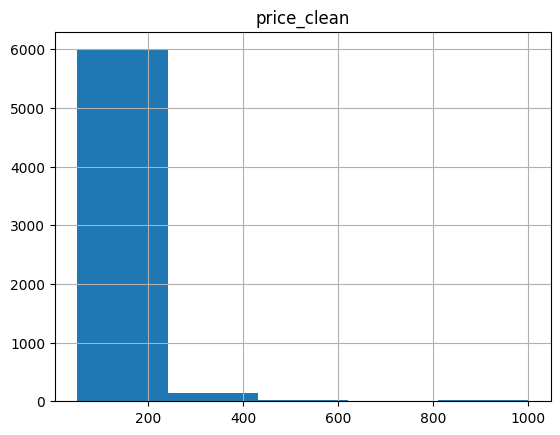

In [16]:
# distribution of prices - INCREASE THE VALUE OF BINS TO GET MORE DETAILS

df.hist("price_clean", bins=5)

## Exercise 3: Choose your important factors (features).

#### To build your model, decide which factors can affect prices the most. You can choose from the 7 possible features listed below by putting your choices in the box of *selected_features*. Mind the syntax!

In [17]:
possible_features = ["accommodates", "host_is_superhost", 
                     "minimum_nights","room_type", "host_identity_verified",  
                     "bedrooms", "property_type"]
                     
# ADD YOUR SELECTIONS BETWEEN THE SQUARE BRACKETS 
selected_features = [ "minimum_nights","room_type","host_is_superhost"]


#### Check out how well your model performs. Feel free to change the features to see how your performance evolves.


In [18]:
def predict_prices(df):

  x = df.loc[:, selected_features]
  y = df.loc[:, ['price_clean']]
  X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=416, train_size = .8)


  ols = linear_model.LinearRegression()
  ols.fit(X_train, y_train)
  ypred = ols.predict(X_test)
  rmse = round(mean_squared_error(ypred, y_test, squared=False),1)
  return(y_test, ypred,rmse)
y_test, ypred, rmse = predict_prices(df)

print("Features used in your model are: {}.".format(", ".join(selected_features)))
print("Average prediction error is {} dollars.".format(rmse))


Features used in your model are: minimum_nights, room_type, host_is_superhost.
Average prediction error is 90.5 dollars.


#### Is the model equally good for cheap and expensive AirBnb predictions? Think of what features may be missing that could improve performance.


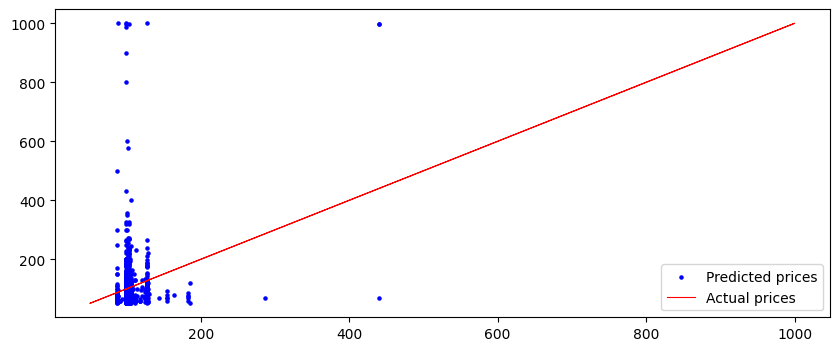

In [21]:
def get_plot(y_test, ypred):

  x_ax = range(len(y_test))
  fig, ax =  plt.subplots(1,1,figsize=(10,4))
  ax.scatter(ypred, y_test, s=5, color="blue", label="Predicted prices")
  ax.plot(y_test, y_test, lw=0.8, color="red", label="Actual prices")
  ax.legend()
  return(fig)
fig = get_plot(y_test, ypred)
#plt.axis([50, 200, 0, 1000])# can zoom in on the graph for more details
plt.show(fig)

#### The more features you have the longer it takes to account for each of them. That's where the machine's help can be useful. 

#### Let's give the machine a list of 10 features and see which ones it finds most useful. 

#### The specific model used here is called Lasso for it tries to tie together the most relevant inputs.


In [22]:
def get_lasso_data(data):

  lasso_df = data[data['property_type'].isin(["Entire rental unit", "Entire serviced apartment",
                              "Private room in rental unit", "Private room in serviced apartment"])]
                              
  lasso_df = lasso_df[(lasso_df['accommodates'] > 1) & (lasso_df['accommodates'] < 7)]
  lasso_df = lasso_df[lasso_df['bedrooms'] < 6]

  lasso_df['price_clean'] = lasso_df['price'].apply(lambda x: int(round(float(x.strip('$').replace(",","")))))
  lasso_df = lasso_df[(lasso_df['price_clean'] > 50) & (lasso_df['price_clean'] <= 1100)]

  lasso_df['calendar_last_scraped'] = lasso_df['calendar_last_scraped'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d'))
  lasso_df['host_since'] = lasso_df['host_since'].fillna('2010-03-26')
  lasso_df['host_since'] = lasso_df['host_since'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d'))

  lasso_df['host_since'] = (lasso_df['calendar_last_scraped'] - lasso_df['host_since'] ).dt.days

  lasso_df['host_identity_verified'] = lasso_df['host_identity_verified'].fillna('f')
  lasso_df = lasso_df[["price_clean", "accommodates", "bedrooms", "property_type","room_type", "host_identity_verified","host_is_superhost","minimum_nights","neighbourhood_cleansed","host_since",
                      "instant_bookable"]]

  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

  num_cols = list(lasso_df.select_dtypes(include=numerics).columns)

  def factorize_text (data, columns):
    data[columns] = list(data[columns].factorize()[0])
    return data

  for col in list(lasso_df.columns):
    if col not in num_cols:
      factorize_text(lasso_df, col)
  return(lasso_df)

lasso_df = get_lasso_data(get_data(city_url))

Lasso picked 6 variables and decided to not use the other 4 variable(s).
Average prediction error is 88.3 dollars.


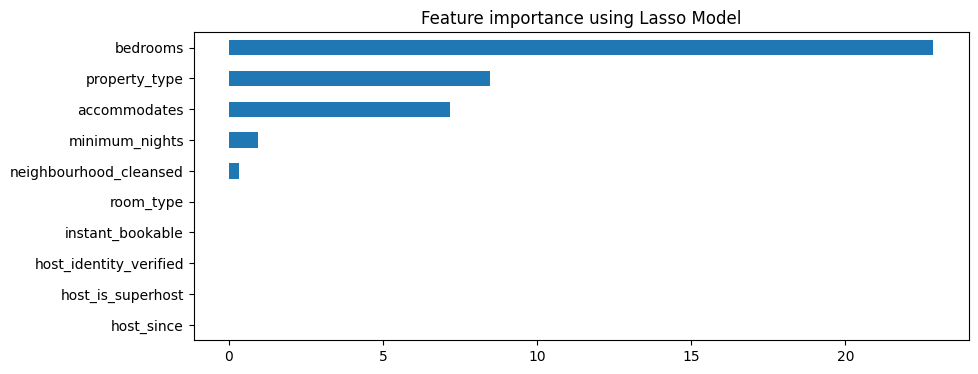

In [23]:
def get_lasso_plot(lasso_df):

  x = lasso_df[list(set(lasso_df.columns) - set(['price_clean']))]  
  y = lasso_df["price_clean"]     
  X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=416, train_size = .8)

  reg = linear_model.Lasso()
  reg.fit(X_train, y_train)

  coef = pd.Series(reg.coef_, index = X_train.columns)

  text = "Lasso picked " + str(sum(coef != 0)) + " variables and decided to not use the other " +  str(sum(coef == 0)) + " variable(s)."

  imp_coef = coef.sort_values()

  fig, ax =  plt.subplots(1,1,figsize=(10,4))
  plt.rcParams['figure.figsize'] = (8.0, 10.0)
  imp_coef.plot(kind = "barh")

  plt.title("Feature importance using Lasso Model")
  ypred = reg.predict(X_test)
  rmse = round(mean_squared_error(ypred, y_test, squared=False),1)
  return(text, fig, rmse, reg, list(X_train.columns))

text, fig2, rmse2, reg, fit_cols = get_lasso_plot(lasso_df)

print(text)
print("Average prediction error is {} dollars.".format(rmse2))
plt.show(fig2)

## Exercise 4: Predict your AirBnb.

#### Now that the machine provided a model for predictions, you can use it to predict how much your desired AirBnb would cost. 

#### Provide a value for all 7 features below. Note that some features require numeric inputs, others are Yes/No questions while room and apartment types have specific text options.  Try to figure out valid inputs based on the rest of the code.

#### If you are unsure of potential values, remember how you can check them.

In [25]:
df.room_type.unique()

array([0, 1])

In [24]:
# CHANGE THE PARAMETERS OF THE FLAT/HOUSE OR USE THE COMMENTED PART BELOW
accommodates = 4

host_is_superhost = 1

minimum_nights = 2

host_identity_verified = 1

bedrooms = 2

property_type = 3

room_type = 0


# TO UNCOMMENT SELECT THE LINES AND PUSH CTRL + '/' ON NUMPAD
# if host_is_superhost == "Yes":
#   host_is_superhost = 1
# else:
#   host_is_superhost = 0

# if room_type == "Home/Apartment":
#   room_type = 1
# else:
#   room_type = 0

# if host_identity_verified == "Yes":
#   host_identity_verified = 1
# else:
#   host_identity_verified = 0

# if property_type == "Entire rental unit":
#   property_type = 0
# elif property_type == "Entire serviced apartment":
#   property_type = 1
# elif property_type == "Private room in rental unit":
#   property_type = 2
# else:
#   property_type = 3


data = pd.DataFrame({'accommodates':accommodates,'bedrooms':bedrooms,'property_type':property_type,
'room_type':room_type,'host_identity_verified':host_identity_verified,'host_is_superhost':host_is_superhost,
'minimum_nights':minimum_nights,'neighbourhood_cleansed':14,'host_since':2833,'instant_bookable':0,}, index=[0])

print("Predicted price for your AirBnb is {} dollars by the Lasso model.".format(round(reg.predict(data[fit_cols])[0]),0))


Predicted price for your AirBnb is 143 dollars by the Lasso model.
